# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
Контролировать добросовестность кассиров при продаже алкоголя.

## Задача проекта 
Обучить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## План проекта 

1. [Исследовательский анализ данных](#EDA)
2. [Обучение модели](#model)
3. [Анализ обученной модели](#concl)

## Исследовательский анализ данных

В следующей ячейке будут храниться импортированные библиотекиь

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Импортируем данные

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=35,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Проведем первичный осмотр данных

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


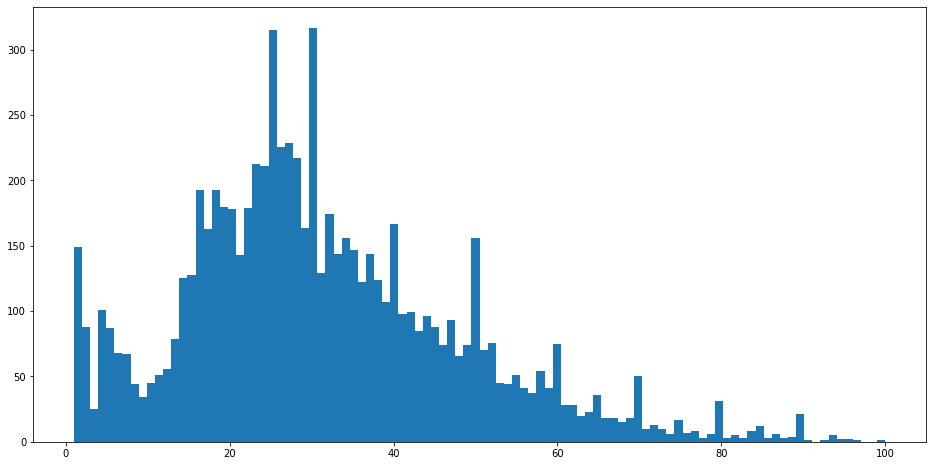

In [5]:
plt.figure(figsize=(16, 8))
plt.hist(labels['real_age'], bins=100)
plt.show()

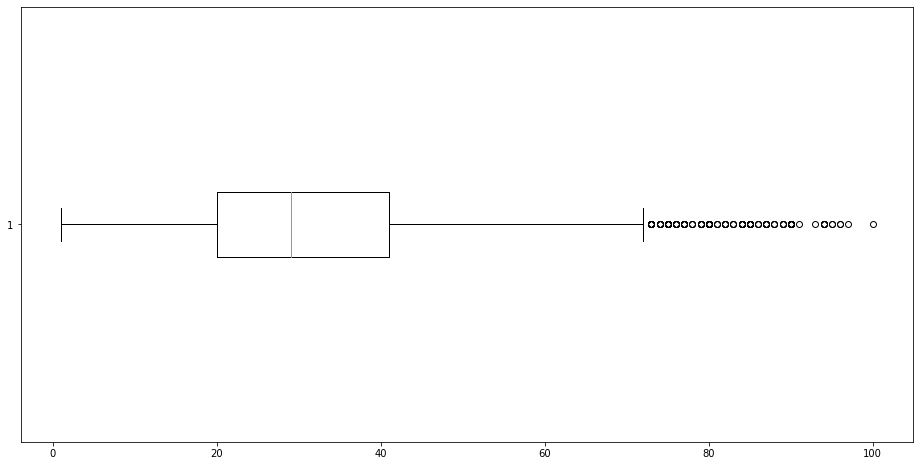

In [6]:
plt.figure(figsize=(16, 8))
plt.boxplot(labels['real_age'], vert=False)
plt.show()

Распределение можно было бы назвать нормальным, если бы не пик 0-10 скорее всего это выбросы, так же выбросами можно считать данные с возрастом более 70 лет, необходимо дополнительно изучить датасет.

In [7]:
features, target = next(train_gen_flow)
features.shape

(35, 224, 224, 3)

Осмотрим данные вызывающие сомнения

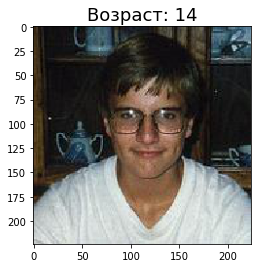

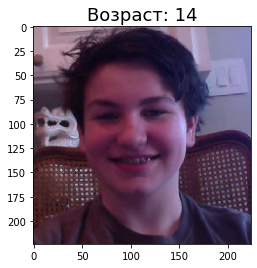

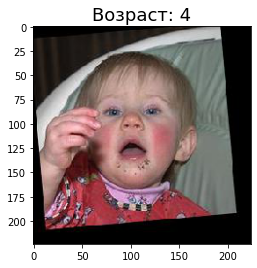

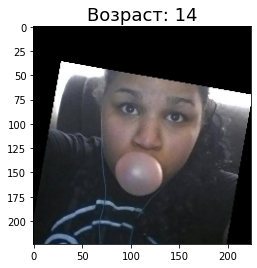

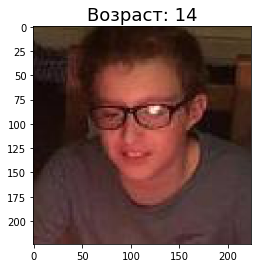

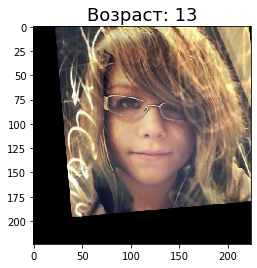

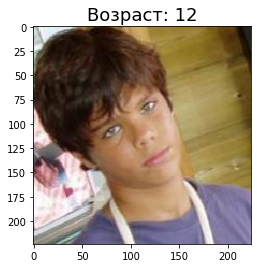

In [8]:
for age, photo in zip(target[:], features[:]):
    if age<15:
        plt.figure()
        plt.title("Возраст: "+ str(age), {'fontsize': 18})
        plt.imshow(photo)

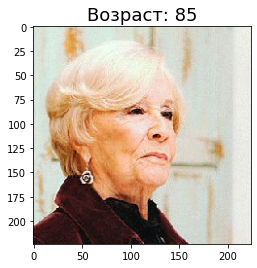

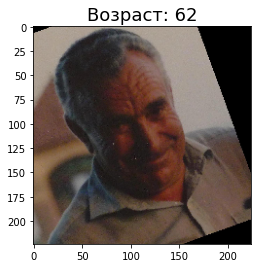

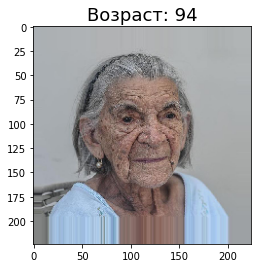

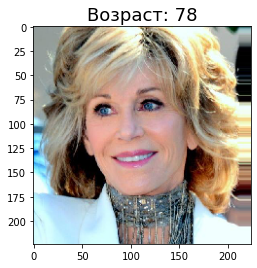

In [9]:
for age, photo in zip(target[:], features[:]):
    if age>60:
        plt.figure()
        plt.title("Возраст: "+ str(age), {'fontsize': 18})
        plt.imshow(photo)

#### Вывод
Данное задание не предполагает глубокой преодобработки данных, но можно сделать вывод, что разметка данных местами спорная. Есть пики на "круглых" датах - вероятно разметчик не мог определить точно и указывал приблизительные возраста. Кроме того данных по фотографиям с малым и большим возрастом довольно мало, вероятно предсказание возраста на этих диапазонах будет менее точным нежели в интервале 15-60 лет.

Часть фотографий повернута, сами фотографии не имеют четкого цветового балланса - есть как фотографии с высокой контрастностью, так есть и практически монохромные. 

## Обучение модели <a id='model'></a>


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

import numpy as np\
import pandas as pd\
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D\
from tensorflow.keras.models import Sequential\
from tensorflow.keras.optimizers import Adam\
from tensorflow.keras.preprocessing.image import ImageDataGenerator\
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):

    labels = pd.read_csv(path+'labels.csv')                                                     
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25, horizontal_flip=True)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=35,
        class_mode='raw',
        subset='training',
        seed=42)
    return train_datagen_flow

def load_test(path):

    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=35,
        class_mode='raw',
        subset='validation', 
        seed=42)
    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 163 steps, validate for 55 steps\
Epoch 1/10\
163/163 - 47s - loss: 245.6653 - mae: 11.1154 - val_loss: 1042.1148 - val_mae: 27.4382\
Epoch 2/10\
163/163 - 38s - loss: 61.4800 - mae: 5.9061 - val_loss: 967.9131 - val_mae: 26.1449\
Epoch 3/10\
163/163 - 38s - loss: 29.5428 - mae: 4.1946 - val_loss: 551.7659 - val_mae: 18.0576\
Epoch 4/10\
163/163 - 38s - loss: 17.7011 - mae: 3.2469 - val_loss: 167.4117 - val_mae: 10.1594\
Epoch 5/10\
163/163 - 38s - loss: 15.0491 - mae: 2.9712 - val_loss: 98.8722 - val_mae: 7.3779\
Epoch 6/10\
163/163 - 40s - loss: 13.0422 - mae: 2.7848 - val_loss: 71.2008 - val_mae: 6.3977\
Epoch 7/10\
163/163 - 48s - loss: 10.2376 - mae: 2.4659 - val_loss: 67.9613 - val_mae: 6.1625\
Epoch 8/10\
163/163 - 52s - loss: 8.0542 - mae: 2.1508 - val_loss: 68.9804 - val_mae: 6.2851\
Epoch 9/10\
163/163 - 50s - loss: 7.8405 - mae: 2.0892 - val_loss: 66.1437 - val_mae: 6.1794\
Epoch 10/10\
163/163 - 49s - loss: 8.1474 - mae: 2.1890 - val_loss: 62.3375 - val_mae: 5.9738

## Анализ обученной модели <a id='concl'></a>

В процессе предобработки данных было выявленно, что датасет имеет распределение близкое к нормальному, но возможно разметка в некоторых случаях не корректна. Так же следует учитывать, что основной массив данных 15-60 лет и точность модели будет будет ниже вне этого дипазона.

В данном случае нам удалось достичь необходимой точности модели, применив ResNet50 c двумя дополнительными слоями. 
Учитывая, что модель строится для определения возраста покупателя в магазине, вероятно следует отсеять лиц моложе 10 лет (допущение что покупателем в данном случае является опекун/родитель сопровождающий такое лицо) и увеличить количество покупателей старшего возраста, таким образом удастся повысить точность модели.  

Основной задачей бизнеса является определение возраста покупателя с последующим таргетированием предложения с такой задачей модель может справится, но стоит учитывать что MAE=5.97 достаточно большое и групп пользователей будет немного и как следствие эффект от внедрения скорее всего будет не велик. Вторичная цель - определение возраста покупателя при продаже товаров с возрастным цензом под вопросом - МАЕ обеспечивает доверительный интервал 15-27 лет при допустимом возрасте продаже 21 год, что очень много и не позволит определить добросовестность кассира. 